In [1]:
### Particle filter simulation program
### Author: Antonio Cruz
### Inspired on the representation and particle filter representation on Ryuichi Ueda's book [Probabilistic Robotics] [詳解確率ロボティクス]
### This program resembles a robot viewed from above, with a sensor which can measure the distance to landmarks in the map
### It uses the Monte Carlo Localization algorithm (Particle filter)

In [2]:
import matplotlib.pyplot as plt #to plot the graphs
import math #for the math functions
import numpy as np #to use nunpy functions and arrays
from matplotlib.animation import FuncAnimation #for the animation
import random #to add random noise to the sensor
from scipy.stats import multivariate_normal
import copy
%matplotlib notebook

In [3]:
#### Clears the Graph ###
def resetGraph():

    fig.clear() #Clears the graph
    plt.xlim([0, 100]) #Again, the limits of the axes
    plt.ylim([0, 100])
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    plt.title('Simulation') #Print the title again

In [4]:
###Class to create a robot object###
class robot:

    def __init__(self, x=0, y=0, angle=0, radius=0, camdist=0, camdof=0, color='black'):
        self.x=x
        self.y=y
        self.angle=angle
        self.radius=radius
        self.color=color
        self.camdist=camdist
        self.camdof=camdof
        #self.m=0

    def draw (self, x, y, angle):
        self.angle=angle #Updates the values of the pose
        self.x=x
        self.y=y

        robo = plt.Circle((x, y), self.radius, facecolor='none', edgecolor=self.color, linewidth='1') #Draws the robot itself
        plt.gca().add_patch(robo)
        angle = (math.pi / 180) * angle
        x2 = self.radius * (math.cos(angle))
        y2 = self.radius * (math.sin(angle))
        #self.m=((y+y2)-y)/((x+x2)-x)

        plt.plot([x, x + x2], [y, y + y2], self.color) ##Draws the line from the center to the outside of the robot

    def camera(self, noiselvl):
        global dist, angles, ln, flag
        dist=[]
        angles=[]

        flag=0 #it indicates if the robot is observing something

        for i in range(ln): #Initializing the lists with control values
            dist.append(0)
            angles.append(0)


        for i in range(ln):
            # Calculates the distance to the landmarks, the range of vision of the camera is 20
            dist[i]=(math.sqrt((math.pow((landmarks[i].x-self.x),2))+(math.pow((landmarks[i].y-self.y),2))))
            # I'm going to calculate the angles to each landmark, I'm using the arctan function to calculate the angle, but next corrections are needed depending on which Quadrant its located

            #arctan(y/x)

            #Making the substraction of coordinates always positive
            resta_y =(landmarks[i].y-self.y)
            resta_x =(landmarks[i].x-self.x)

            if resta_y < 0:
                resta_y*=-1
            if resta_x < 0:
                resta_x*=-1



            #This is the formula to calculate the angle to each landmark
            angles[i] = ((math.atan(resta_y/resta_x)) * (180 / math.pi))


            ###Corrections depending on the Quadrant
            #QUADRANT I - No correction needed
            #Quadrant II
            if (landmarks[i].x - self.x) < 0 and (landmarks[i].y - self.y) > 0:
                angles[i]= 180 - angles[i]
            #Quadrant III
            if (landmarks[i].x - self.x) < 0 and (landmarks[i].y - self.y) < 0:
                angles[i] += 180
            #Quadrant IV
            if (landmarks[i].x - self.x) > 0 and (landmarks[i].y - self.y) < 0:
                angles[i] = 360 - angles[i]

        #< >
        ###Conditions of the camera, distance and degrees of vision
        for i in range(ln):
            if dist[i] <= self.camdist:
                if (angles[i]-self.angle) > -(self.camdof/2) and (angles[i]-self.angle) < (self.camdof/2):

                    ##Adding noise to the measurements
                    if noiselvl == 1:
                        dist[i] += (random.randint(-5, 5))  # Distance noise
                        angles[i] += (random.randint(-3, 3))  # Angle noise
                    if noiselvl == 2:
                        dist[i] += (random.randint(-15, 15))  # Distance noise
                        angles[i] += (random.randint(-10, 10))  # Angle noise


                    #Calculates the coordinates to the point after the noise
                    x2 = dist[i] * (math.cos((math.pi / 180) * angles[i]))
                    y2 = dist[i] * (math.sin((math.pi / 180) * angles[i]))

                    plt.plot([self.x, self.x + x2], [self.y, self.y + y2], color='red')  ##Draws the line to the landmarks
                    flag=1
                    global band
                    band=i ##Indicates the number of the landmark the robot is observing


In [5]:
###Class to create a particle

class particle:

    def __init__(self, x=0, y=0, angle=0, weight=0):
        self.x=x
        self.y=y
        self.angle=angle
        self.weight=weight
        self.color="yellow"
        self.transparency=0.3
        self.dist_tnl=0
        self.angle_tnl=0

    def update(self):
        #Updates the position of the particles and adds some noise
        global v, w, tinterval

        nr=[0.3, 0.08, 0.15, 0.3]
        nr_res=[0,0,0,0]
        for i in range(4):
            y = multivariate_normal(mean=0, cov=math.pow(nr[i],2))
            nr_res[i]=y.rvs()

        pv= v + (nr_res[0] * math.sqrt(abs(v)/tinterval)) + (nr_res[1] * math.sqrt(abs(w)/tinterval))
        pw= w + (nr_res[2] * math.sqrt(abs(v)/tinterval)) + (nr_res[3] * math.sqrt(abs(w)/tinterval))

        self.x += pv * math.cos((math.pi / 180) * self.angle)
        self.y += pv * math.sin((math.pi / 180) * self.angle)
        self.angle += pw
        if self.angle >= 360:  # To have always a value on the range of 360 degrees
            self.angle = 0

    def obs(self):
        global flag, band

        if flag==1: #When a landmark is observed
            self.dist_tnl = (math.sqrt((math.pow((landmarks[band].x - self.x), 2)) + (math.pow((landmarks[band].y - self.y), 2))))


            # Making the substraction of coordinates always positive
            resta_y = (landmarks[band].y - self.y)
            resta_x = (landmarks[band].x - self.x)

            if resta_y < 0:
                resta_y *= -1
            if resta_x < 0:
                resta_x *= -1

            # This is the formula to calculate the angle to each landmark
            self.angle_tnl = ((math.atan(resta_y / resta_x)) * (180 / math.pi))

            ###Corrections depending on the Quadrant
            # QUADRANT I - No correction needed
            # Quadrant II
            if (landmarks[band].x - self.x) < 0 and (landmarks[band].y - self.y) > 0:
                self.angle_tnl = 180 - self.angle_tnl
            # Quadrant III
            if (landmarks[band].x - self.x) < 0 and (landmarks[band].y - self.y) < 0:
                self.angle_tnl += 180
            # Quadrant IV
            if (landmarks[band].x - self.x) > 0 and (landmarks[band].y - self.y) < 0:
                self.angle_tnl = 360 - self.angle_tnl




    ### Observation and particle weight function

    def obs_update(self):
        global flag, band, dist, angles

        dist_dev_r=0.14
        angle_dev= 3

        self.obs()

        if flag==1:

            x2 = dist[band] * (math.cos((math.pi / 180) * angles[band]))
            y2 = dist[band] * (math.sin((math.pi / 180) * angles[band]))

            x3 = self.dist_tnl * (math.cos((math.pi / 180) * angles[band]))
            y3 = self.dist_tnl * (math.sin((math.pi / 180) * angles[band]))

            dist_dev = dist_dev_r * self.dist_tnl

            pos_lm_r=[dist[band],   angles[band] ]
            pos_obs_part = [self.dist_tnl,   self.angle_tnl]


            cov = np.diag(np.array([math.pow(dist_dev, 2), math.pow(angle_dev, 2)]))
            self.weight *= multivariate_normal(mean=pos_obs_part, cov=cov).pdf(pos_lm_r)






    #Function to draw the particles

    def draw (self):

        global pn

        angle = (math.pi / 180) * self.angle

        x2 = 1  * (math.cos(angle))
        y2 = 1  * (math.sin(angle))

        flecha = plt.arrow(self.x, self.y, x2, y2, head_width= 1,  color="purple", alpha=self.transparency)
        plt.gca().add_patch(flecha)

In [6]:
###Class to create a landmark

class landmark:
    def __init__(self, x=0, y=0, color='green',label='lol'):
        self.x=x
        self.y=y
        self.color=color
        self.label=label

    def draw(self):
        plt.plot([self.x], [self.y], marker='*', markersize=7, color=self.color)
        plt.annotate(self.label,(self.x-1,self.y-5))

In [7]:
##Resampling function
def resampling():
    global pn, part
    part_sum=0
    part_w_list=[]

    for i in range(pn):
        part_sum+=part[i].weight
        part_w_list.append(part[i].weight)

    if part_sum < 1e-100:
        for i in range(pn):
           part_w_list[i]=1e-100

    part_selected = random.choices(part,weights=part_w_list,k=pn)
    part=[copy.deepcopy(i) for i in part_selected]

    for i in range(pn):
        part[i].weight=1/pn

In [8]:
####Initialization of every object #####
#Stablishing the initial pose of the robot and the landmarks

def inicializacion():
    global xr, yr, theta, landmarks , part, ln, pn, v, w, t, tinterval

    #Initial pose of the robot
    xr=50
    yr=50
    theta=0

    #time at the begining of the program
    t=0
    tinterval=1

    #Control orders for the robot
    v=1 #1m every time
    w=5 #turn of 5 degrees (deg)

    #Number of landmarks
    ln=3
    #Landmarks list
    landmarks=[]
    #Number of particles
    pn=30
    #particles list
    part=[]

    # Creation of landmarks
    for i in range(ln):
        landmarks.append(landmark(0, 0, 'green', ("l" + str(i + 1))))

    #creation of particles
    for i in range(pn):
        part.append(particle(xr,yr,0,1/pn))



    global rob1
    # Initializes the robot (X, Y, theta, Radius, distance of vision of camera, Angle of vision of the camera, color)
    rob1 = robot(xr, yr, theta, 2, 50, 60, 'blue')



    ###Initial coordinate values for each landmark
    landmarks[0].x=60
    landmarks[0].y=80
    landmarks[1].x=20
    landmarks[1].y=30
    landmarks[2].x=70
    landmarks[2].y=40
    # landmarks[3].x=30
    # landmarks[3].y=80
    # landmarks[4].x=90
    # landmarks[4].y=50

In [9]:
###Parameters to make the robot move in a circle
def robotCirculo():
    global xr, yr, theta, v, w
    ##Just move forward 1 in the direction of the angle of the robot

    xr += v * math.cos((math.pi / 180) * theta)
    yr += v * math.sin((math.pi / 180) * theta)
    theta+=w
    if theta == 360: #To have always a value on the range of 360 degrees
        theta=0

In [10]:
###Principal function###

def principal(i):

    global xr,yr, theta, ln, pn, t, tinterval
    resetGraph()

    for i in range(ln):
        landmarks[i].draw()

    robotCirculo()


    rob1.camera(1) #Camera with the noise level 0=ideal camera, 1=a little bit of noise, 2= 激しいnoise

    for j in range(pn):

        part[j].update()
        part[j].obs_update()

        #print(str(j) + " " + str(part[j].weight))
        part[j].draw()

    resampling()
    rob1.draw(xr,yr,theta)



    plt.annotate(("t = " + str(t)), (10, 90))
    t+=tinterval;

<IPython.core.display.Javascript object>


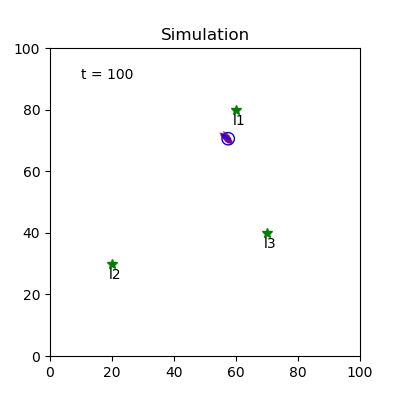

In [11]:
#### Initialization of the graph(map) ###
fig, ax = plt.subplots(figsize=(4, 4))

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')

plt.xlim([0, 100]) #Limits of the axes
plt.ylim([0, 100])
plt.title('Simulation')

inicializacion() ##Initialization of the program variables and functions


#                            Funcion a llamar,             inicio, fin, step      el intervalo
#animation = FuncAnimation(fig, func=principal, frames= np.arange(0, 10, 1), interval=1)
animation = FuncAnimation(fig, func=principal, frames= 100, interval=10, repeat=False)

plt.show()